For this analysis, we will be using data from the [Progresa program](http://en.wikipedia.org/wiki/Oportunidades), a government social assistance program in Mexico. This program, as well as the details of its impact, are described in the paper "[School subsidies for the poor: evaluating the Mexican Progresa poverty program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)", by Paul Shultz (available on Canvas). 

The goal of this problem set is to implement some of the basic econometric techniques that you are learning in class to measure the impact of Progresa on secondary school enrollment rates. The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
The data are actual data collected to evaluate the impact of the Progresa program.  In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are surveyed in each year. For each child-year observation, the following variables are collected:

| Variable name | Description|
|---------|---------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = 'pobre'|
|progresa |treatment = 'basal'|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	  |gender of head of household (male=1)|
|hohage   |age of head of household|
|age      |years old|
|folnum	  |individual id|
|village  |	village id|
|sc97	  |schooling in 1997|

In [755]:
import sys; print(sys.version)
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.formula.api import ols

3.6.0 |Anaconda 4.3.0 (64-bit)| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]


---
##Part 1: Descriptive analysis

### 1.1	Summary Statistics

a) Present number of missing observations for every single variable


In [756]:
df = pd.read_csv("progresa_sample.csv")
df.head()

,year,sex,indig,dist_sec,sc,grc,fam_n,min_dist,dist_cap,poor,...,hohedu,hohwag,welfare_index,hohsex,hohage,age,village,folnum,grc97,sc97
0,97,0.000000,0.000000,4.473000,1.000000,7.000000,7,21.168384,21.168384,pobre,...,6,0.000000,583.000000,1.000000,35.000000,13,163,1,7,1.000000
1,98,0.000000,0.000000,4.473000,1.000000,8.000000,7,21.168384,21.168384,pobre,...,6,0.000000,583.000000,1.000000,35.000000,14,163,1,7,1.000000
2,97,1.000000,0.000000,4.473000,1.000000,6.000000,7,21.168384,21.168384,pobre,...,6,0.000000,583.000000,1.000000,35.000000,12,163,2,6,1.000000
3,98,1.000000,0.000000,4.473000,1.000000,7.000000,7,21.168384,21.168384,pobre,...,6,0.000000,583.000000,1.000000,35.000000,13,163,2,6,1.000000
4,97,0.000000,0.000000,4.473000,1.000000,2.000000,7,21.168384,21.168384,pobre,...,6,0.000000,583.000000,1.000000,35.000000,8,163,3,2,1.000000


In [757]:
df_countnull = df.isnull().sum()
type(df_countnull)
df_countnull = pd.DataFrame({'Variable':df_countnull.index, 'Count of missing values':df_countnull.values})
df_countnull[['Variable','Count of missing values']]

,Variable,Count of missing values
0,year,0
1,sex,24
2,indig,300
3,dist_sec,0
4,sc,8453
5,grc,6549
6,fam_n,0
7,min_dist,0
8,dist_cap,0
9,poor,0


b) Present summary statistics (mean and standard deviation) for all of the demographic variables in the dataset (i.e., everything except year, folnum, village). 

In [758]:
df_new = df[df.columns.difference(['year','folnum','village'])]
result = df_new.describe()
result.ix[['mean','std']]

,age,dist_cap,dist_sec,fam_n,grc,grc97,hohage,hohedu,hohsex,hohwag,indig,min_dist,sc,sc97,sex,welfare_index
mean,11.366460,147.674452,2.418910,7.215715,3.963537,3.705372,44.436717,2.768104,0.925185,586.985312,0.298324,103.447520,0.819818,0.813922,0.512211,690.346564
std,3.167744,76.063134,2.234109,2.352900,2.499063,2.572387,11.620372,2.656106,0.263095,788.133664,0.457525,42.089441,0.384342,0.389172,0.499854,139.491130


### 1.2 Differences at baseline?

Are the baseline (1997) demographic characteristics **for the poor**  different in treatment and control villages? Hint: Use a T-Test to determine whether there is a statistically significant difference in the average values of each of the variables in the dataset. Focus only on the data from 1997 for individuals who are poor (i.e., poor=='pobre').

In [759]:
df_poor = df.loc[(df.year == 97) & (df.poor == 'pobre')]

In [760]:
treatment = df_poor.loc[df_poor.progresa=='basal']
control = df_poor.loc[df_poor.progresa=='0']

In [761]:
treatment = treatment[treatment.columns.difference(['year','folnum','village'])]
control = control[control.columns.difference(['year','folnum','village'])]

desc1 = treatment.describe()
t_mean = desc1.loc['mean']

df1 = pd.DataFrame({'Variable name':t_mean.index, 'Average value (Treatment villages)':t_mean.values},
                        columns = ['Variable name','Average value (Treatment villages)'])

desc2 = control.describe()
c_mean = desc2.loc['mean']

df2 = pd.DataFrame({'Variable name':c_mean.index,'Average value (Control villages)':c_mean.values},
                      columns = ['Variable name','Average value (Control villages)'])
result_df=pd.merge(df1,df2, on = 'Variable name')

In [762]:
#treatment = treatment.fillna(0)
#control = control.fillna(0)

# Calculating p-value for continuous variable

#Saving p-value in a dict
p = {}

#Age
p = {'age': ttest_ind(treatment.age,control.age,nan_policy='omit').pvalue}
#dist_sec
p.update({'dist_sec': ttest_ind(treatment.dist_sec,control.dist_sec,nan_policy='omit').pvalue})
#grc
p.update({'grc': ttest_ind(treatment.grc,control.grc,nan_policy='omit').pvalue})
#min_dist
p.update({'min_dist': ttest_ind(treatment.min_dist,control.min_dist,nan_policy='omit').pvalue})
#fam_n
p.update({'fam_n': ttest_ind(treatment.fam_n,control.fam_n,nan_policy='omit').pvalue})
#dist_cap
p.update({'dist_cap': ttest_ind(treatment.dist_cap,control.dist_cap,nan_policy='omit').pvalue})
#hohedu
p.update({'hohedu': ttest_ind(treatment.hohedu,control.hohedu,nan_policy='omit').pvalue})
#hohwag
p.update({'hohwag': ttest_ind(treatment.hohwag,control.hohwag,nan_policy='omit').pvalue})
#hohage
p.update({'hohage': ttest_ind(treatment.hohage,control.hohage,nan_policy='omit').pvalue})
#grc97
p.update({'grc97': ttest_ind(treatment.grc97,control.grc97,nan_policy='omit').pvalue})
#indig
p.update({'indig': ttest_ind(treatment.indig,control.indig,nan_policy='omit').pvalue})
#hohsex
p.update({'hohsex': ttest_ind(treatment.hohsex,control.hohsex,nan_policy='omit').pvalue})
#sc
p.update({'sc': ttest_ind(treatment.sc,control.sc,nan_policy='omit').pvalue})
#sc97
p.update({'sc97': ttest_ind(treatment.sc97,control.sc97,nan_policy='omit').pvalue})
#sex
p.update({'sex': ttest_ind(treatment.sex,control.sex,nan_policy='omit').pvalue})
#welfare_index
p.update({'welfare_index': ttest_ind(treatment.welfare_index,control.welfare_index,nan_policy='omit').pvalue})

df3 = pd.DataFrame(list(p.items()),
                  columns = ['Variable name','p-value'])

In [763]:
# Calculating p-value for continuous variable

#Saving p-value in a dict
p = {}

#Age
p = {'age': ttest_ind(treatment.age,control.age,nan_policy='omit').statistic}
#dist_sec
p.update({'dist_sec': ttest_ind(treatment.dist_sec,control.dist_sec,nan_policy='omit').statistic})
#grc
p.update({'grc': ttest_ind(treatment.grc,control.grc,nan_policy='omit').statistic})
#min_dist
p.update({'min_dist': ttest_ind(treatment.min_dist,control.min_dist,nan_policy='omit').statistic})
#fam_n
p.update({'fam_n': ttest_ind(treatment.fam_n,control.fam_n,nan_policy='omit').statistic})
#dist_cap
p.update({'dist_cap': ttest_ind(treatment.dist_cap,control.dist_cap,nan_policy='omit').statistic})
#hohedu
p.update({'hohedu': ttest_ind(treatment.hohedu,control.hohedu,nan_policy='omit').statistic})
#hohwag
p.update({'hohwag': ttest_ind(treatment.hohwag,control.hohwag,nan_policy='omit').statistic})
#welfare_index
p.update({'welfare_index': ttest_ind(treatment.welfare_index,control.welfare_index,nan_policy='omit').statistic})
#hohage
p.update({'hohage': ttest_ind(treatment.hohage,control.hohage,nan_policy='omit').statistic})
#grc97
p.update({'grc97': ttest_ind(treatment.grc97,control.grc97,nan_policy='omit').statistic})
#indig
p.update({'indig': ttest_ind(treatment.indig,control.indig,nan_policy='omit').statistic})
#hohsex
p.update({'hohsex': ttest_ind(treatment.hohsex,control.hohsex,nan_policy='omit').statistic})
#sc
p.update({'sc': ttest_ind(treatment.sc,control.sc,nan_policy='omit').statistic})
#sc97
p.update({'sc97': ttest_ind(treatment.sc97,control.sc97,nan_policy='omit').statistic})
#sex
p.update({'sex': ttest_ind(treatment.sex,control.sex,nan_policy='omit').statistic})
#welfare_index
p.update({'welfare_index': ttest_ind(treatment.welfare_index,control.welfare_index,nan_policy='omit').statistic})

df4 = pd.DataFrame(list(p.items()),
                  columns = ['Variable name','Difference(Treat - Control)'])

In [764]:
pd.options.display.float_format = '{:,.6f}'.format
diff_df = result_df.merge(df3,on='Variable name').merge(df4,on='Variable name')
diff_df

,Variable name,Average value (Treatment villages),Average value (Control villages),p-value,Difference(Treat - Control)
0,age,10.716991,10.742023,0.478559,-0.708630
1,dist_cap,150.829074,153.769730,0.000842,-3.339081
2,dist_sec,2.453122,2.507662,0.035698,-2.100433
3,fam_n,7.281327,7.302469,0.427104,-0.794167
4,grc,3.531599,3.543050,0.689015,-0.400196
5,grc97,3.531599,3.543050,0.689015,-0.400196
6,hohage,43.648828,44.276918,0.000002,-4.775962
7,hohedu,2.663139,2.590348,0.011051,2.541229
8,hohsex,0.924656,0.922947,0.571186,0.566312
9,hohwag,544.339544,573.163558,0.000325,-3.594588


### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages as baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

In [765]:
diff_df['Is Significant'] = np.where(diff_df['p-value']< 0.05, 'Yes', 'No')
diff_significant = diff_df[diff_df['Is Significant'] == 'Yes']
diff_significant

,Variable name,Average value (Treatment villages),Average value (Control villages),p-value,Difference(Treat - Control),Is Significant
1,dist_cap,150.829074,153.769730,0.000842,-3.339081,Yes
2,dist_sec,2.453122,2.507662,0.035698,-2.100433,Yes
6,hohage,43.648828,44.276918,0.000002,-4.775962,Yes
7,hohedu,2.663139,2.590348,0.011051,2.541229,Yes
9,hohwag,544.339544,573.163558,0.000325,-3.594588,Yes
11,min_dist,107.152915,103.237854,0.000000,8.206584,Yes
14,sex,0.519317,0.505052,0.012192,2.506686,Yes
15,welfare_index,655.428377,659.579100,0.001431,-3.188594,Yes


A: Are there statistically significant differences between treatment and control villages as baseline?

Considering statistical significance is based on p-value, we identify variables which have p-value < 0.05 to be statistically significant. Thus from the table, we can say that dist_cap, dist_sec, hohage, hohedu, hohwag, min_dist, sex & welfare_index variables were significantly different at the baseline.

B: Why does it matter if there are differences at baseline?

In order to understand the actual effect of the treatment, we need to have a same baseline between the treatment & control groups. If the baseline is different, then the sample is not fully randomized and might impact the results of the study.

C: What does this imply about how to measure the impact of the treatment?

Since there is a difference between some of the variables in treatment & control group, exact impact of the treatment cannot be measured.

### 1.4 Graphical exploration, part 1

For each level of household head education, compute the average enrollment rate in 1997. Create a scatterplot that shows this relationship. What do you notice?

In [766]:
df_97 = df[df.year == 97] 
df_ho = df_97.groupby(['hohedu','sc97']).sc97.agg(['count'])
#print(df_ho)
df_ho = df_ho.unstack('sc97')
df_records = pd.DataFrame(df_ho.to_records())
#print(df_ho)
df_records.columns = ['EducationLevelOfHead','CountNotEnrolled','CountEnrolled']
df_records = df_records.fillna(0)
df_records['Enrollment Rate'] = (df_records.CountEnrolled)/(df_records.CountNotEnrolled + df_records.CountEnrolled)
df_records

,EducationLevelOfHead,CountNotEnrolled,CountEnrolled,Enrollment Rate
0,0,"2,229.000000","7,728.000000",0.776137
1,1,590.000000,"1,959.000000",0.768537
2,2,"1,154.000000","4,463.000000",0.794552
3,3,"1,453.000000","5,921.000000",0.802956
4,4,430.000000,"2,308.000000",0.842951
5,5,182.000000,"1,030.000000",0.849835
6,6,635.000000,"4,590.000000",0.878469
7,7,19.000000,153.000000,0.889535
8,8,29.000000,261.000000,0.900000
9,9,80.000000,987.000000,0.925023


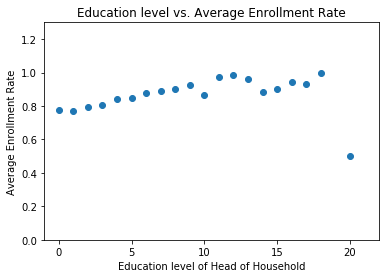

In [767]:
plt.scatter(df_records.EducationLevelOfHead,df_records['Enrollment Rate'])
plt.xlim(-1,22)
plt.ylim(0, 1.3)
plt.ylabel('Average Enrollment Rate')
plt.xlabel('Education level of Head of Household')
plt.title('Education level vs. Average Enrollment Rate')

The above scatter plot says that as the education level of the household head increases, the average enrollment rate increases (except for 10 years & around 13 years where there is slight drop in the avg enrollment rate). The outlier here is the average enrollment rate for the highest education level of household head since it is significantly lower from the rest of the cases.

### 1.5 Graphical exploration, part 2

Create a histogram of village enrollment rates **among poor households in treated villages**, before and after treatment. Specifically, for each village, calculate the average rate of enrollment of poor households in treated villages in 1997, then compute the average rate of enrollment of poor households in treated villages in 1998. Create two separate histograms showing the distribution of these average enrollments rates, one histogram for 1997 and one histogram for 1998. On each histogram, draw a vertical line that intersects the x-axis at the average value (across all households).
* Does there appear to be a difference? Is this difference statistically significant?
* Which D estimator in Schultz (2004) does this approach correspond to?

In [768]:
df_97 = df.loc[(df.year == 97) & (df.poor == 'pobre') & (df.progresa == 'basal')]
df_ho = df_97.groupby(['village','sc']).sc97.agg(['count'])
#print(df_ho)
df_ho = df_ho.unstack('sc')
df_records_97 = pd.DataFrame(df_ho.to_records())
#print(df_records)
df_records_97.columns = ['Village','CountNotEnrolled','CountEnrolled']
df_records_97 = df_records_97.fillna(0)
df_records_97['Enrollment Rate'] = (df_records_97.CountEnrolled)/(df_records_97.CountNotEnrolled + df_records_97.CountEnrolled)
df_records_97.head()

,Village,CountNotEnrolled,CountEnrolled,Enrollment Rate
0,1,35.000000,106.000000,0.751773
1,2,21.000000,45.000000,0.681818
2,4,25.000000,275.000000,0.916667
3,5,2.000000,48.000000,0.960000
4,6,2.000000,55.000000,0.964912


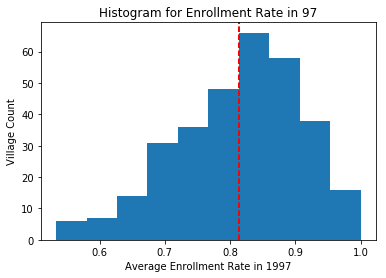

In [769]:
plt.hist(df_records_97['Enrollment Rate'])
plt.axvline(df_records_97['Enrollment Rate'].mean(),color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Average Enrollment Rate in 1997')
plt.ylabel('Village Count')
plt.title('Histogram for Enrollment Rate in 97')

In [770]:
df_98 = df.loc[(df.year == 98) & (df.poor == 'pobre') & (df.progresa == 'basal')]
df_ho = df_98.groupby(['village','sc']).sc.agg(['count'])
#print(df_ho)
df_ho = df_ho.unstack('sc')
df_records_98 = pd.DataFrame(df_ho.to_records())
#print(df_records)
df_records_98.columns = ['Village','CountNotEnrolled','CountEnrolled']
df_records_98 = df_records_98.fillna(0)
df_records_98['Enrollment Rate'] = (df_records_98.CountEnrolled)/(df_records_98.CountNotEnrolled + df_records_98.CountEnrolled)
df_records_98.head()

,Village,CountNotEnrolled,CountEnrolled,Enrollment Rate
0,1,26.000000,104.000000,0.800000
1,2,16.000000,40.000000,0.714286
2,4,19.000000,255.000000,0.930657
3,5,15.000000,75.000000,0.833333
4,6,5.000000,51.000000,0.910714


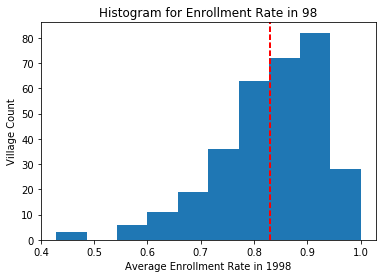

In [771]:
plt.hist(df_records_98['Enrollment Rate'])
plt.axvline(df_records_98['Enrollment Rate'].mean(),color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Average Enrollment Rate in 1998')
plt.ylabel('Village Count')
plt.title('Histogram for Enrollment Rate in 98')

In [772]:
#Calculating means, t statistic & p value

print ('Mean of Average Enrollment Rate in 1997', df_records_97['Enrollment Rate'].mean())
print ('Mean of Average Enrollment Rate in 1998', df_records_98['Enrollment Rate'].mean())

t_value = stats.ttest_ind(df_records_97['Enrollment Rate'],df_records_98['Enrollment Rate'], nan_policy='omit').statistic
p_value = stats.ttest_ind(df_records_97['Enrollment Rate'],df_records_98['Enrollment Rate'], nan_policy='omit').pvalue

print('t statistic is ', t_value)
print('pvalue is ', p_value)

Mean of Average Enrollment Rate in 1997 0.8138394110596501
Mean of Average Enrollment Rate in 1998 0.8295362042630732
t statistic is  -2.01571348652
pvalue is  0.0442487003657


* Does there appear to be a difference? Is this difference statistically significant?
The mean of average enrollment rate increases only slightly from 1997 (0.813) to 1998 (0.829). However, the t test gives a 
statistically significant value which means that the difference in average enrollment rate between 1997 & 1998 is significant.

* Which D estimator in Schultz (2004) does this approach correspond to?
This corresponds to DD1 estimator in Schultz which is the difference in averages before & after program.

## Part 2: Measuring Impact

### 2.1 Simple differences: T-test

Start out by estimating the impact of Progresa using "simple differences." Restricting yourself to data from 1998 (after treatment).
* calculate the average enrollment rate among **poor** households in the Treatment villages and the average enrollment rate among **poor** households in the control villages.
* Which difference estimator in Schultz (2004) does this approach correspond to?
* Use a t-test to determine if this difference is statistically significant. What do you conclude?

In [773]:
t_98 = df.loc[(df.year == 98) & (df.poor == 'pobre') & (df.progresa == 'basal')]
c_98 = df.loc[(df.year == 98) & (df.poor == 'pobre') & (df.progresa == '0')]

t_98_avg_sc = t_98.mean()['sc']
c_98_avg_sc= c_98.mean()['sc']

print('Average enrollment rate among poor households in the Treatment villages  is :',t_98_avg_sc)
print('Average enrollment rate among poor households in the Control villages  is :',c_98_avg_sc)

Average enrollment rate among poor households in the Treatment villages  is : 0.846479121395
Average enrollment rate among poor households in the Control villages  is : 0.80763695673


Which difference estimator in Schultz (2004) does this approach correspond to?

This approach corresponds to D1 difference estimator in Schultz which is difference in post-program averages among treatment & control groups.

Use a t-test to determine if this difference is statistically significant. What do you conclude?

In [774]:
t_statistic = stats.ttest_ind(t_98['sc'],c_98['sc'], nan_policy='omit').statistic
p_value = stats.ttest_ind(t_98['sc'],c_98['sc'], nan_policy='omit').pvalue
print('t statistic : ', t_statistic)
print('pvalue : ', p_value)

t statistic :  8.35872056742
pvalue :  6.63634444738e-17


From the t-test, the pvalue is lower than 0.05 and hence the difference between the treatment & control group is statistically significant.

### 2.2 Simple differences: Regression

Estimate the effects of Progresa on enrollment using a regression model, by regressing the 1998 enrollment rates **of the poor** on treatment assignment.

In [775]:
poor_98 = df[(df.poor=='pobre') & (df.year==98)]
lm = ols(formula = 'sc ~ progresa', data = poor_98).fit()
print(lm.summary())
print(lm.params)

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     69.87
Date:                Tue, 02 May 2017   Prob (F-statistic):           6.64e-17
Time:                        15:27:12   Log-Likelihood:                -11926.
No. Observations:               27450   AIC:                         2.386e+04
Df Residuals:                   27448   BIC:                         2.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             0.8076      0.00

* Based on this model, how much did Progresa increase the likelihood of a child enrolling?

Progresa increased the likelihood of a child enrolling by 0.0388 units. From the p-value, there is an increase of 0.0388 in the average enrollment rate due to Progresa. The intercept says that in the absence of treatment, the average enrollment rate would have been 0.8076 units.

* How does your regression estimate compare to your t-test estimate from part 2.1?

The regression estimate from the summary of the linear regression is 8.359 which is the same as the t-test estimate fromom 2.1

* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 

Yes, we can reject the null hypothesis that the treatment effects are zero since the p-value is statistically significant.

* What is the counterfactual assumption underlying this regression?

The counterfactual assumption is that if there was no treatment, the average enrollment rates in the treatment & control groups would have been the same.

### 2.3 Multiple Regression

Re-run the above regression estimated but this time include a set of control variables. Include, for instance, age, distance to a secondary school, gender, education of household head, indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

In [776]:
lm2 = ols(formula = 'sc ~ progresa + sex + indig + dist_sec + fam_n + min_dist + dist_cap + hohedu + hohwag + welfare_index + age + hohage',data = poor_98).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     849.5
Date:                Tue, 02 May 2017   Prob (F-statistic):               0.00
Time:                        15:27:12   Log-Likelihood:                -7541.1
No. Observations:               27263   AIC:                         1.511e+04
Df Residuals:                   27250   BIC:                         1.521e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             1.4431      0.01

How do the controls affect the point estimate of treatment effect?

From the summary of the multiple regression parameters, the p-value is 0.0337 which is lower than p-value without controls added(0.0388). Also, the R-squared value is 0.272 compared to 0.003 earlier, which says that the controls have a significant impact on the point estimate.

How do the controls affect the standard error on the treatment effect?

The standard error before that treatment was 0.005 while the standard error after treament is 0.004. Thus the point estimate improves with addition of controls.

How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

The intercept value increases from 0.807 to 1.443 which says that in the absence of the treatment, the avg enrollment is higher when control variables are introduced. Also,  we see that as the distance of secondary school increases by 1 unit, the avg enrollment rate decreases by 0.0106 units. Another interesting thing is as the age of the head of household increases by 1 unit, the enrollment rate drops by -2.299e-05 units.

### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the difference in 1998 enrollment rates across villages. An alternative approach would be to compute the treatment effect using a difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages; then compute the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages. The difference between these two differences is your estimate.

* What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?
* What is the counterfactual assumption underlying this estimate? 


In [777]:
t_97 = df.loc[(df.year == 97) & (df.poor == 'pobre') & (df.progresa == 'basal')]
c_97 = df.loc[(df.year == 97) & (df.poor == 'pobre') & (df.progresa == '0')]

t_98 = df.loc[(df.year == 98) & (df.poor == 'pobre') & (df.progresa == 'basal')]
c_98 = df.loc[(df.year == 98) & (df.poor == 'pobre') & (df.progresa == '0')]


t_avg_97 = t_97.mean()['sc']
c_avg_97 = c_97.mean()['sc']
t_c_diff_97 = t_avg_97 - c_avg_97

t_avg_98 = t_98.mean()['sc']
c_avg_98 = c_98.mean()['sc']
t_c_diff_98 = t_avg_98 - c_avg_98

diff = t_c_diff_98 - t_c_diff_97
print(diff)

0.0313312803193


What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?
The estimate of the impact using the difference-in-differences framework is 0.0313. This value is lesser than the simple difference obtained from multiple regression(0.0337) & linear regression(0.0388)

What is the counterfactual assumption underlying this estimate?

The counterfactual assumption is that if there was no treatment, the trends in average enrollment rates in the treatment & control groups would have been the same.

### 2.5 Difference-in-Difference, version 1 (regression)

Now use a regression specification to estimate the average treatment effect of the program (on the poor) in a difference-in-differences framework. Include at least 5 control variables.

* What is your estimate of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.
* How do these estimates of the treatment effect compare to the estimates based on the simple difference?
* How do these estimates compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences?
* What is the counterfactual assumption underlying this regression? 

In [778]:
df.loc[df['poor'] == 'pobre', 'poorBinary'] = 1
df.loc[df['poor'] ==  'no pobre', 'poorBinary'] = 0

df.loc[df.year == 97, 'yearBinary'] = 0
df.loc[df.year == 98, 'yearBinary'] = 1

df_poor = df[(df.poorBinary == 1)]

lm3 = ols(formula='sc ~ progresa + yearBinary + progresa*yearBinary + age + indig + dist_sec + sex + hohedu', data=df_poor).fit()

print(lm3.summary())


                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     2810.
Date:                Tue, 02 May 2017   Prob (F-statistic):               0.00
Time:                        15:27:14   Log-Likelihood:                -16717.
No. Observations:               58165   AIC:                         3.345e+04
Df Residuals:                   58156   BIC:                         3.353e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept       

What is your estimate of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.

Binary variable for year is created since the control variable has to be binary. We call it yearBinary.
Interpretations:
1)The interaction between the treatment term and the year is interpretted as "progresa:yearBinary" which is the interaction coefficient. Thus as per this variable, in 1998, the average enrollment rates would be 0.0314 higher in the treatment group. 
2)From the variable yearBinary, the average enrollment rate increases by 0.0270 in 1998. 
3)The progresa coefficient has the value 0.0043 but it is no longer statistically significant.

How do these estimates of the treatment effect compare to the estimates based on the simple difference?

The estimates of the treatment effect are lesser compared to the estimates based on the simple difference. The difference in difference approach is better compared to simple difference since we consider the interaction variable which helps in considering both treatment & control variables together instead of taking them independently.

How do these estimates compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences?

These estimates are almost similar to the estimates in 2.4 above. However, here we have 3 variables due to the introduction of the interaction variable. Hence, this variable has caused slightly different changes in all the estimates.

What is the counterfactual assumption underlying this regression?

The counterfactual assumption is that the trends in treatment and control groups would have been the same in the absence of treatment as well.

### 2.6 Difference-in-Difference, version 2

In the previous problem, you estimated a difference-in-differences model that compared changes in enrollment rates over time across treatment and control villages. An alternative approach would be to compare enrollment rates in 1998 between poor and non-poor across treatment and control villages. 

* How would we estimate this version of the treatment effects in a regression model? 
* What is the counterfactual assumption underlying this regression?
* How do these treatment effects compare to the estimates above?
* Discuss some possible explanations for differences or similarities 

In [779]:
df_98 = df[df['year'] == 98]

lm4 = ols(formula = 'sc ~ progresa + poorBinary + progresa*poorBinary + sex + dist_sec  + min_dist + dist_cap + hohedu + age', data=df_98).fit()

lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     1344.
Date:                Tue, 02 May 2017   Prob (F-statistic):               0.00
Time:                        15:27:14   Log-Likelihood:                -9237.3
No. Observations:               32097   AIC:                         1.849e+04
Df Residuals:                   32087   BIC:                         1.858e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept                        1.4816      0.012    122.903      0.000         1.458     1.505
progresa[T.basal]                0.0250      0.010      2.583      0.010         0.006     0.044
poorBinary                      -0.0211      0.008     -2.558      0.011        -0.037    -0.005
progresa[T.basal]:poorBinary     0.0094      0.010      0.894      0.371        -0.011     0.030
sex                              0.0306      0.004      8.493      0.000         0.024     0.038
dist_sec                        -0.0105      0.001    -12.741      0.000        -0.012    -0.009
min_dist                         0.0003   5.92e-05      5.736      0.000         0.000     0.000
dist_cap                         0.0003   3.28e-05      9.368      0.000         0.000     0.000
hohedu                           0.0085      0.001     12.210      0.000         0.007     0.010
age                             -0.0661      0.001   -103.966      0.000        -0.067    -0.065
==============================================================================
Omnibus:                     3179.660   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4231.906
Skew:                          -0.888   Prob(JB):                         0.00
Kurtosis:                       3.111   Cond. No.                     1.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

How would we estimate this version of the treatment effects in a regression model?

Binary variable for poor is created since the control variable has to be binary. We call it poorBinary.
Interpretations:
1)The interaction between the treatment term and the year is interpretted as "progresa:poorBinary" which is the interaction coefficient. Thus as per this variable, in 1998, the average enrollment rates would be 0.0094 higher in the poor group. This however, is not statistically significant.
2)From the variable poorBinary, the average enrollment rate decreases by 0.0211 in 1998.This means the enrollment rate in poor households reduced by 0.0211 units in 1998.
3)The progresa coefficient has the value 0.025 & is statistically significant.This means the enrollment rate increased by 0.025 due to Progresa program.

What is the counterfactual assumption underlying this regression?

The counterfactual assumption is that the average enrollment rates would have been the same in poor & non-poor groups in absense of the treatment.

How do these treatment effects compare to the estimates above?

The estimates of the treatment effect are lesser compared to the estimates based on the simple difference. The p value for the interaction term is not statistically significant in this case & also the enrollment rate has lowered in poor groups in 1998 (since poorBinary value is negative).

Discuss some possible explanations for differences or similarities

The reason for the difference can be because only poor households are supposed to be a part of this program. Considering non-poor households has made the interaction term statistically insignificant.

### 2.7 Spillover effects (extra credit)

Thus far, we have focused on the impact of PROGRESA on poor households. Repeat your analysis in 2.5, using a double-difference regression to estimate the impact of PROGRESA on non-poor households. In other words, compare the difference in enrollments between 1997 and 1998 for non-poor households in treatment villages with the difference in enrollments between 1997 and 1998 for non-poor households in control villages.

* A: Describe one or two reasons why PROGRESA might have impacted non-poor households.
* B: Do you observe any impacts of PROGRESA on the non-poor?
* C: What is the identifying assumption that you are using to estimate the impact of PROGRESA on non-poor households.

In [780]:
df_not_poor = df[df['poorBinary'] == 0]

lm5 = ols(formula = 'sc ~ progresa + yearBinary + progresa*yearBinary + sex + dist_sec  + min_dist + dist_cap + hohedu + age + hohage', data=df_not_poor).fit()

lm5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     428.9
Date:                Tue, 02 May 2017   Prob (F-statistic):               0.00
Time:                        15:27:14   Log-Likelihood:                -3659.7
No. Observations:               10423   AIC:                             7341.
Df Residuals:                   10412   BIC:                             7421.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept                        1.4739      0.024     61.795      0.000         1.427     1.521
progresa[T.basal]                0.0249      0.009      2.692      0.007         0.007     0.043
yearBinary                       0.0387      0.011      3.600      0.000         0.018     0.060
progresa[T.basal]:yearBinary    -0.0027      0.014     -0.194      0.846        -0.030     0.024
sex                              0.0310      0.007      4.595      0.000         0.018     0.044
dist_sec                        -0.0154      0.002     -8.730      0.000        -0.019    -0.012
min_dist                     -7.307e-05      0.000     -0.632      0.527        -0.000     0.000
dist_cap                         0.0006   7.47e-05      8.638      0.000         0.000     0.001
hohedu                           0.0091      0.001      7.645      0.000         0.007     0.011
age                             -0.0685      0.001    -60.095      0.000        -0.071    -0.066
hohage                        6.824e-05      0.000      0.203      0.839        -0.001     0.001
==============================================================================
Omnibus:                      845.143   Durbin-Watson:                   1.504
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              802.020
Skew:                          -0.618   Prob(JB):                    6.98e-175
Kurtosis:                       2.437   Cond. No.                     1.27e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A: Progresa would have helped provide publicity in the neighborhood by word of mouth or government advertising which have encouraged non-poor households to enroll their children as well.
B: There is an average increase in enrollment in 1998 0.0387 which shows that there was an impact.
C: The assumption being used here is that, there were no other factors impacting non-poor households to enroll their children apart from the Progresa program.

### 2.8 Summary

Based on all the analysis you have undertaken to date, do you thik that Progresa had a causal impact on the enrollment rates of poor households in Mexico?

Yes, Progresa had an impact on the enrollment rates of the poor households in Mexico, although it is not very high. Since it is a randomized trial, we can say that there was a causal impact. However, we cannot prove the counterfactual assumption that the average enrollment rate would have been the same in treatment & control groups in the absense of the treatment.

As in every causal study, we need to consider 3 possible reasons that might have impacted the outcome of the study. Only when you rule out the other possible reasons, you can guarantee that there was a definite impact of the treatment on the group.

Also, since this is a study which can go on for a long period of time, analysing long term outcomes can be more impactful instead of just guaging the impact for a period of one year.

Overall, since Progresa showed a small increase in average enrollment in just 1 year, this could be a good investment by the government & can be used as a model to start other subsidy programs as well.